# RevenueMagnetML

In [1]:
#importing all necessary libraries

# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#----regular expressions----
import re

#----model and support imports----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

# Feature Engineering
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Deployment
from flask import Flask, render_template, request
import pickle

# Set the default style for plotting
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading dataset
df = pd.read_csv('data_Saas_sales.csv')

# Display the first few rows of the dataset to get an overview
df.head()

,Opportunity ID,Account ID 18 Digits,Opportunity Owner,Amount (converted),Stage,Created Date,Close Date,Age,Lead Source,Employees,Industry,Market Segment
0,00606000012b5JF,0010600001z3JtmAAE,AE 5,4000.00,Closed Lost,01/08/2022,1/25/2022,17,Partner Referral,NaN,Food & Beverage - Restaurants,NaN
1,00606000012b3w0,0010600001z3DY6AAM,AE 6,4235.35,Closed Lost,01/06/2022,02/02/2022,27,Inbound,NaN,Agencies / Consultancies / Software Providers ...,NaN
2,00606000012b4vX,0010600001z3IFzAAM,AE 5,4000.00,Closed Won,01/08/2022,02/07/2022,30,Inbound,476.0,Food & Beverage - Delivery Services,Corporate
3,00606000012bJiw,0010600001z5DWaAAM,AE 4,4235.35,Closed Lost,02/01/2022,02/12/2022,11,Inbound,NaN,Agencies / Consultancies / Software Providers,NaN
4,00606000012bCpU,0010600001z4R6PAAU,AE 4,4000.00,Closed Lost,1/20/2022,2/25/2022,36,Inbound,NaN,Mobility & Transportation - Logistics,NaN


We'll drop the "Opportunity ID" and "Account ID 18 Digits" columns and handle missing values in the "Industry," "Employees," and "Market Segment" columns.

In [3]:
# Drop 'Opportunity ID' and 'Account ID 18 Digits'
df.drop(['Opportunity ID', 'Account ID 18 Digits'], axis=1, inplace=True)

##### Handling Missing Values
1. Industry Column</br>
For the "Industry" column, since it's a categorical variable, we can fill missing values with a label like "Unknown."

In [4]:
df['Industry'].fillna('Unknown', inplace=True)

2. Employees Column</br>
For the "Employees" column, which seems to be numerical, we can impute missing values with the mean.

In [5]:
# Fill missing values in 'Employees' with the mean and convert to integer
df['Employees'] = df['Employees'].fillna(df['Employees'].mean()).astype(int)

3. Market Segment Column</br>
For the "Market Segment" column, we can use the mode (most frequent value) to fill missing values.

In [6]:
df['Market Segment'].fillna(df['Market Segment'].mode()[0], inplace=True)

4. Amount(Converted)</br>
It looks like there are missing values in the "Amount (converted)" column with mean values

In [7]:
# Fill missing values in 'Amount (converted)' with the mean
df['Amount (converted)'].fillna(df['Amount (converted)'].mean(), inplace=True)

3. Lead Source</br>
For the "Lead Source" column, we can use the mode (most frequent value) to fill missing values.

In [8]:
# Fill missing values in 'Lead Source' with the mode
df['Lead Source'].fillna(df['Lead Source'].mode()[0], inplace=True)

Checking for Remaining Missing Values</br>
Let's check if there are any remaining missing values in the dataset.

In [9]:
missing_values = df.isnull().sum()
print("Remaining Missing Values:\n", missing_values)

Remaining Missing Values:
 Opportunity Owner     0
Amount (converted)    0
Stage                 0
Created Date          0
Close Date            0
Age                   0
Lead Source           0
Employees             0
Industry              0
Market Segment        0
dtype: int64


##### Multi-Stage Classification:
Keep the stages as separate classes, creating a multiclass classification problem.</br>
Combine stages like "Qualifying," "Scoping," "Signing," "Contracting," "Proving," and "Negotiating" into a broader category (e.g., "In Progress" or "Intermediate").</br>
Treat "Closed Lost" and "Closed Won" as distinct classes.</br>
This way, we retain the complexity of predicting specific stages while also simplifying some of the intermediate stages. It strikes a balance between simplicity and granularity

In [10]:
# Create a new column 'Opportunity_Status' based on the 'Stage' column
df['Opportunity_Status'] = df['Stage'].apply(lambda x: 'In Progress' if x in ['Qualifying', 'Scoping', 'Signing', 'Contracting', 'Proving', 'Negotiating'] else x)

# Display the distribution of opportunities across different stages
stage_distribution = df['Opportunity_Status'].value_counts()
print("Opportunity Distribution across Stages:\n", stage_distribution)

Opportunity Distribution across Stages:
 Opportunity_Status
Closed Lost    287
In Progress    116
Closed Won      72
Name: count, dtype: int64


In [11]:
df.sample(10)

,Opportunity Owner,Amount (converted),Stage,Created Date,Close Date,Age,Lead Source,Employees,Industry,Market Segment,Opportunity_Status
462,AE 6,97633.20,Qualifying,12/16/2022,9/30/2023,103,Inbound,2445,Financial Services,Corporate,In Progress
468,AE 9,120000.00,Scoping,11/12/2022,10/28/2023,137,Inbound,2445,security & investigations,Corporate,In Progress
362,AE 4,48000.00,Closed Lost,1/22/2022,3/23/2023,425,Inbound,2445,Food & Beverage - Delivery Services,Corporate,Closed Lost
262,AE 1,1500.00,Closed Lost,9/15/2022,1/13/2023,120,Outbound,2445,Financial Services,Corporate,Closed Lost
355,AE 4,120000.00,Closed Lost,12/20/2022,3/22/2023,92,Outbound,2445,Unknown,Corporate,Closed Lost
401,AE 4,96000.00,Proving,08/10/2022,6/30/2023,231,Inbound,2445,Financial Services,Corporate,In Progress
400,AE 9,348000.00,Proving,12/31/2022,6/24/2023,88,Inbound,2445,Food & Beverage - Grocery Shops,Corporate,In Progress
282,AE 4,10460.70,Closed Lost,8/16/2022,1/20/2023,157,Inbound,2445,internet,Corporate,Closed Lost
77,AE 6,4202.45,Closed Lost,4/30/2022,6/29/2022,60,Inbound,2445,information technology and services,Corporate,Closed Lost
178,AE 4,1750.00,Closed Lost,5/18/2022,10/11/2022,146,Inbound,2445,Other Consumer Goods - Automotive,Corporate,Closed Lost


### Data Visualisation

Visualizing the Distribution of Opportunities across Stages:

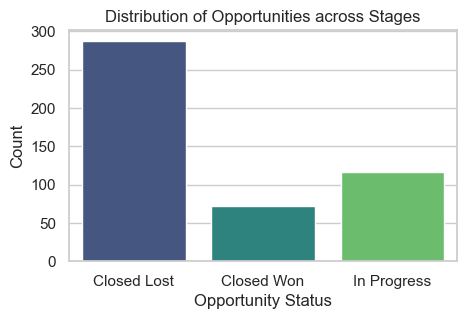

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of opportunities across different stages
plt.figure(figsize=(5, 3))
sns.countplot(x='Opportunity_Status', data=df, palette='viridis')
plt.title('Distribution of Opportunities across Stages')
plt.xlabel('Opportunity Status')
plt.ylabel('Count')
plt.show()

correlation between numerical columns

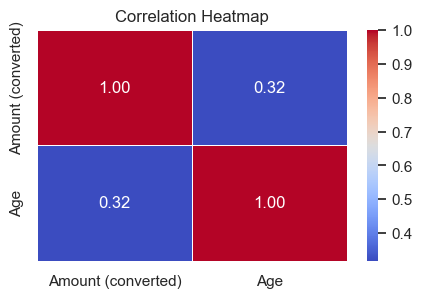

In [13]:
# Select numerical columns for correlation heatmap
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Create a correlation matrix for numerical columns
correlation_matrix = df[numerical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Distribution of Amount (converted) by Opportunity Status:

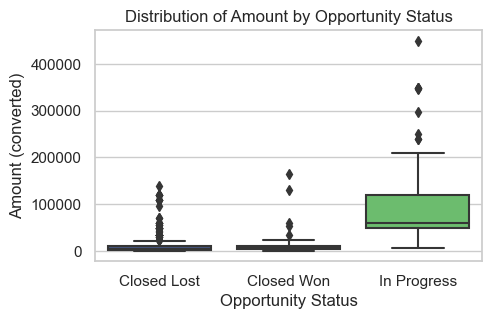

In [14]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='Opportunity_Status', y='Amount (converted)', data=df, palette='viridis')
plt.title('Distribution of Amount by Opportunity Status')
plt.xlabel('Opportunity Status')
plt.ylabel('Amount (converted)')
plt.show()

Opportunity Age Distribution

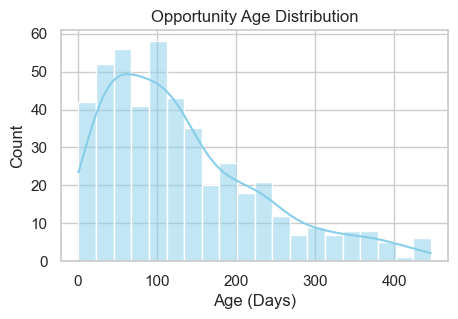

In [15]:
plt.figure(figsize=(5, 3))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Opportunity Age Distribution')
plt.xlabel('Age (Days)')
plt.ylabel('Count')
plt.show()

Lead Source Distribution

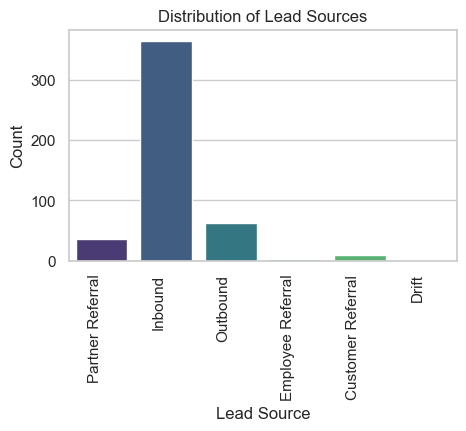

In [16]:
plt.figure(figsize=(5, 3))
sns.countplot(x='Lead Source', data=df, palette='viridis')
plt.title('Distribution of Lead Sources')
plt.xlabel('Lead Source')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

Opportunity Status by Industry

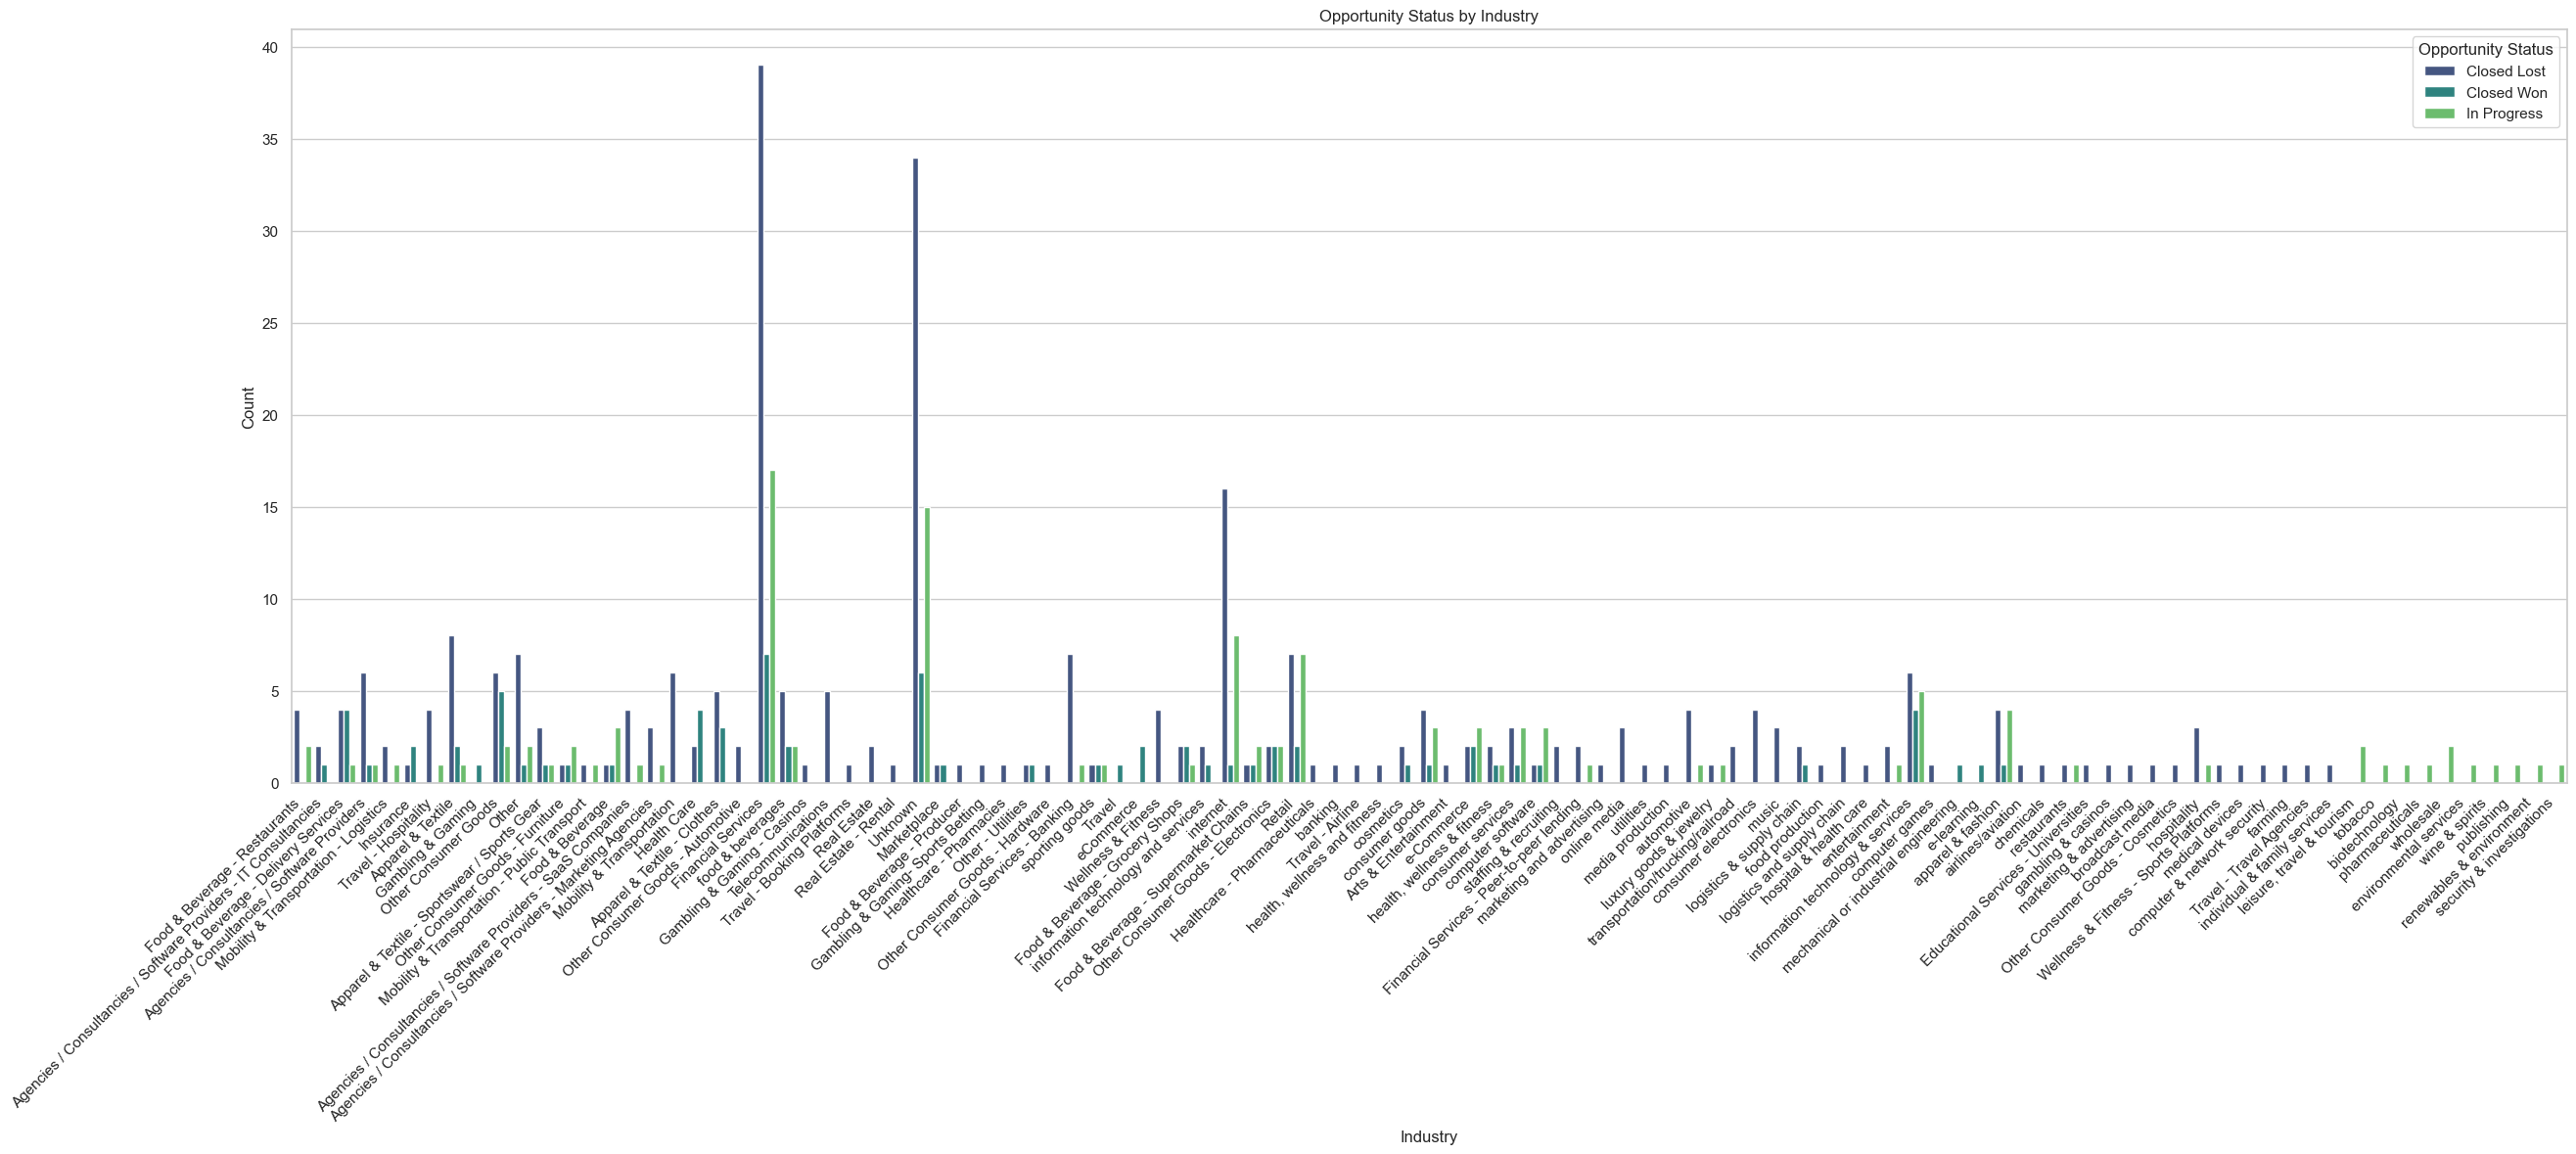

In [17]:
plt.figure(figsize=(30, 10))
sns.countplot(x='Industry', hue='Opportunity_Status', data=df, palette='viridis')
plt.title('Opportunity Status by Industry')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Opportunity Status')
plt.show()

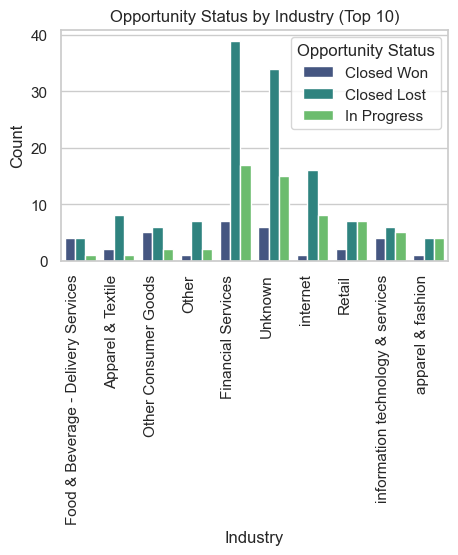

In [18]:
# Select the top 10 most frequent industries
top_industries = df['Industry'].value_counts().nlargest(10).index

# Filter the data to include only the top industries
df_top_industries = df[df['Industry'].isin(top_industries)]

# Plot the count plot for the top industries
plt.figure(figsize=(5, 3))
sns.countplot(x='Industry', hue='Opportunity_Status', data=df_top_industries, palette='viridis')
plt.title('Opportunity Status by Industry (Top 10)')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Opportunity Status')
plt.show()

#### Time-Series Analysis:

Let's start by exploring the time distribution of opportunities. We can create a time series plot to visualize how the number of opportunities varies over different periods. 

In [19]:
# Convert 'Created Date' to datetime format
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Extract year and month separately
df['Year'] = df['Created Date'].dt.year
df['Month'] = df['Created Date'].dt.month_name()

# Create a new feature for the formatted date
df['Formatted Created Date'] = df['Month'] + ' ' + df['Year'].astype(str)

In [20]:
# Convert 'Created Date' to datetime format
df['Close Date'] = pd.to_datetime(df['Close Date'])

# Extract year and month separately
df['Year'] = df['Close Date'].dt.year
df['Month'] = df['Close Date'].dt.month_name()

# Create a new feature for the formatted date
df['Formatted Close Date'] = df['Month'] + ' ' + df['Year'].astype(str)

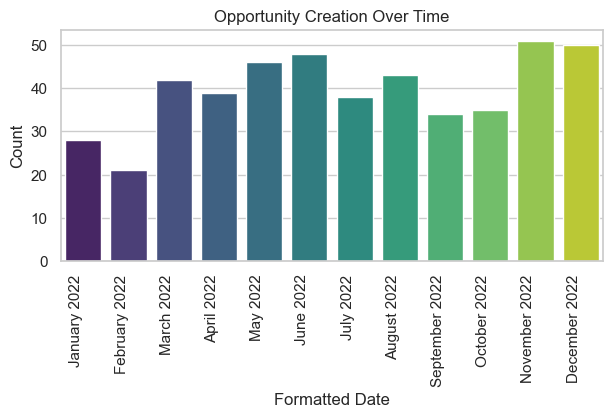

In [21]:
# Plot the time series with the new formatted date
plt.figure(figsize=(7, 3))
sns.countplot(x='Formatted Created Date', data=df, palette='viridis')
plt.title('Opportunity Creation Over Time')
plt.xlabel('Formatted Date')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

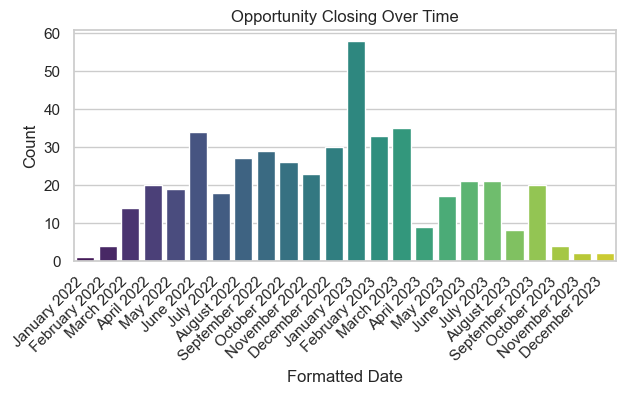

In [22]:
# Plot the time series with the new formatted date
plt.figure(figsize=(7, 3))
sns.countplot(x='Formatted Close Date', data=df, palette='viridis')
plt.title('Opportunity Closing Over Time')
plt.xlabel('Formatted Date')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

##### Outlier Detection

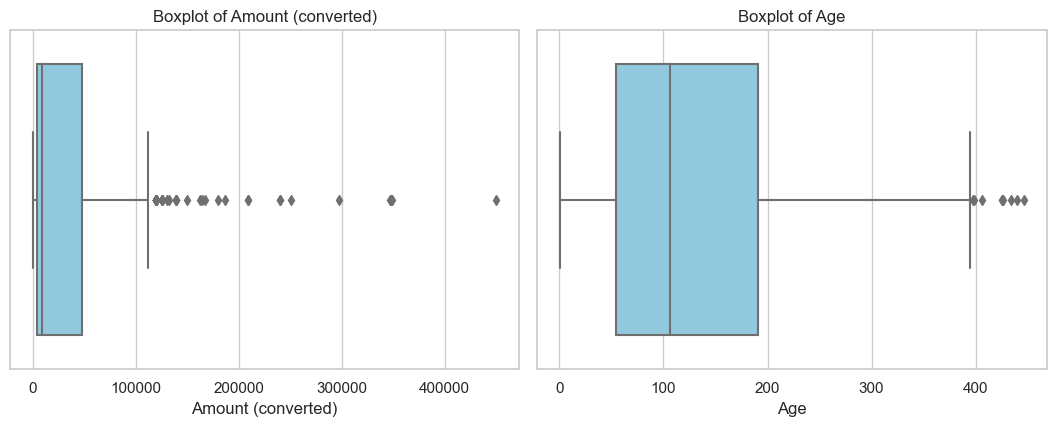

In [23]:
# Select numerical columns for outlier detection
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for numerical columns to visualize outliers
plt.figure(figsize=(16, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[column], color='skyblue')
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Since there can be corporates with 70K+employees and a deal with 40K+ value, we can neglect that and move forward

Lets move to creating a pair plot for numerical features and color the points based on the "Opportunity_Status"

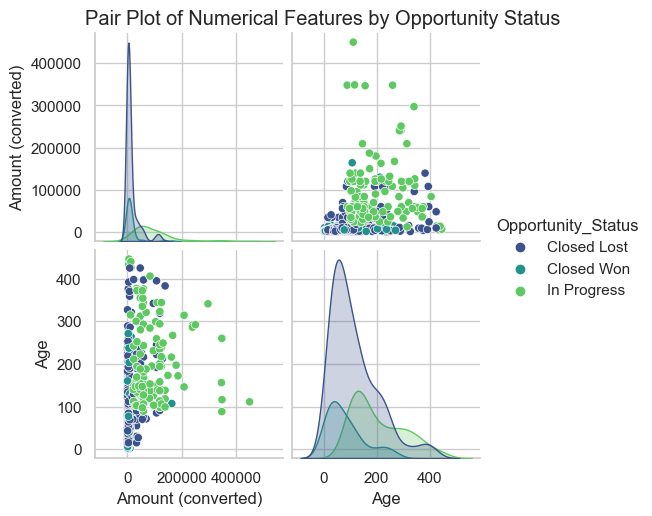

In [24]:
# Select numerical columns for pair plot
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Add the 'Opportunity_Status' column to the selected columns
selected_columns = ['Opportunity_Status'] + list(numerical_columns)

# Create a pair plot
pair_plot = sns.pairplot(df[selected_columns], hue='Opportunity_Status', palette='viridis')
pair_plot.fig.suptitle('Pair Plot of Numerical Features by Opportunity Status', y=1.02)
plt.show()


##### Handling categorical features

Handling categorical features involves exploring their distribution and understanding their relationship with the target variable. Visualizing categorical features can provide insights into how different categories impact the target variable.

Let's consider visualizing the distribution of a specific categorical feature, and then we can explore its relationship with the target variable.

Since we already visualised the impact of Lead source Over Opportuity Status, lets check how it relates to the "Opportunity_Status."

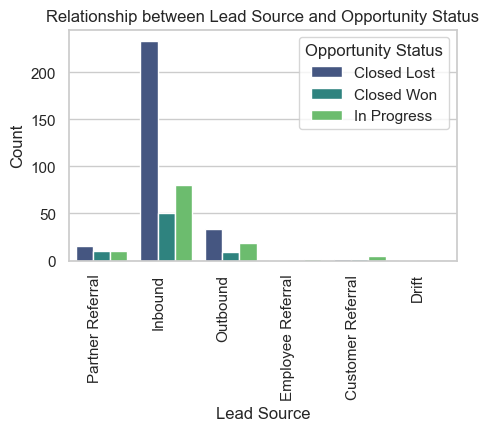

In [25]:
# Visualize the relationship between 'Lead Source' and 'Opportunity_Status'
plt.figure(figsize=(5, 3))
sns.countplot(x='Lead Source', hue='Opportunity_Status', data=df, palette='viridis')
plt.title('Relationship between Lead Source and Opportunity Status')
plt.xlabel('Lead Source')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Opportunity Status')
plt.show()

#### Data Distibution

Closed Lost: 287 opportunities</br>
In Progress: 116 opportunities</br>
Closed Won: 72 opportunities</br>

##### Imbalance in Opportunity Distribution: 
The distribution is imbalanced, with "Closed Lost" opportunities being more prevalent. In machine learning models, dealing with imbalanced classes may require special attention during model training to avoid biased results.

Dealing with imbalanced data is an important step, especially when we're working on a classification problem with significantly uneven class distributions. Imbalanced data can lead to biased models, where the algorithm may be more inclined to predict the majority class, and the performance on the minority class could be compromised.

### Data Preprocessing and Splitting

Let's define X and y and address the label encoding. We'll use label encoding for the target variable and one-hot encoding for the categorical features.

In [26]:
# Define X and y
X = df.drop('Opportunity_Status', axis=1)
y = LabelEncoder().fit_transform(df['Opportunity_Status'])

In [27]:
# Defining X_train, X_valid, y_train, y_valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Split the data into training, validation, and test sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

# Display the shapes of the resulting sets
print(f"Training Set Shape: {X_train.shape}")
print(f"Validation Set Shape: {X_valid.shape}")
print(f"Test Set Shape: {X_test.shape}")

Training Set Shape: (285, 14)
Validation Set Shape: (95, 14)
Test Set Shape: (95, 14)


In [29]:
# Define numerical and categorical features
numerical_features = ['Amount (converted)', 'Age', 'Employees']
categorical_features = ['Opportunity Owner', 'Stage', 'Lead Source', 'Industry', 'Market Segment']

# Define the pipeline with multiple classifiers using imbalanced-learn's Pipeline
pipelines = {
    'RandomForest': ImbPipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ]
        )),
        ('resampler', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': ImbPipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ]
        )),
        ('resampler', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'LogisticRegression': ImbPipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ]
        )),
        ('resampler', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(random_state=42))
    ])
}

# Train and evaluate each model
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    accuracy = pipeline.score(X_valid, y_valid)
    print(f'{name} - Validation Accuracy: {accuracy}')

RandomForest - Validation Accuracy: 0.9894736842105263
XGBoost - Validation Accuracy: 1.0
LogisticRegression - Validation Accuracy: 0.9894736842105263


In [30]:
# Train and evaluate each model
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    
    accuracy = pipeline.score(X_valid, y_valid)
    report = classification_report(y_valid, y_pred)
    
    print(f'{name} - Validation Accuracy: {accuracy}')
    print(f'{name} - Classification Report:')
    print(report)

RandomForest - Validation Accuracy: 0.9894736842105263
RandomForest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      0.93      0.96        14
           2       0.96      1.00      0.98        23

    accuracy                           0.99        95
   macro avg       0.99      0.98      0.98        95
weighted avg       0.99      0.99      0.99        95

XGBoost - Validation Accuracy: 1.0
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        23

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

LogisticRegression - Validation Accuracy: 0.9894736842105263
LogisticRegressi

In [31]:
# Test the models on the test set
for name, pipeline in pipelines.items():
    accuracy_test = pipeline.score(X_test, y_test)
    y_pred_test = pipeline.predict(X_test)
    report_test = classification_report(y_test, y_pred_test)

    print(f'{name} - Test Accuracy: {accuracy_test}')
    print(f'{name} - Test Classification Report:')
    print(report_test)

RandomForest - Test Accuracy: 1.0
RandomForest - Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        35

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

XGBoost - Test Accuracy: 1.0
XGBoost - Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        35

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

LogisticRegression - Test Accuracy: 1.0
LogisticRegression - Test Classification Report:
     

In [32]:
import joblib

# Save the RandomForest model to a file
joblib.dump(pipelines['RandomForest'], 'random_forest_model.joblib')

['random_forest_model.joblib']

In [34]:
from sklearn.compose import TransformedTargetRegressor

# Train and evaluate each model
for name, pipeline in pipelines.items():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Extract feature names from preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    transformed_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(transformed_feature_names)

    # Print feature names
    print(f'{name} - Feature Names Used for Training:')
    print(all_feature_names)

    # Evaluate accuracy
    accuracy = pipeline.score(X_valid, y_valid)
    print(f'{name} - Validation Accuracy: {accuracy}')

RandomForest - Feature Names Used for Training:
['Amount (converted)', 'Age', 'Employees', 'Opportunity Owner_1', 'Opportunity Owner_2', 'Opportunity Owner_3', 'Opportunity Owner_4', 'Opportunity Owner_5', 'Opportunity Owner_6', 'Opportunity Owner_7', 'Opportunity Owner_8', 'Opportunity Owner_9', 'Opportunity Owner_10', 'Opportunity Owner_11', 'Opportunity Owner_12', 'Opportunity Owner_13', 'Opportunity Owner_14', 'Opportunity Owner_15', 'Opportunity Owner_16', 'Opportunity Owner_17', 'Stage_1', 'Stage_2', 'Stage_3', 'Stage_4', 'Stage_5', 'Stage_6', 'Stage_7', 'Stage_8', 'Lead Source_1', 'Lead Source_2', 'Lead Source_3', 'Lead Source_4', 'Lead Source_5', 'Industry_1', 'Industry_2', 'Industry_3', 'Industry_4', 'Industry_5', 'Industry_6', 'Industry_7', 'Industry_8', 'Industry_9', 'Industry_10', 'Industry_11', 'Industry_12', 'Industry_13', 'Industry_14', 'Industry_15', 'Industry_16', 'Industry_17', 'Industry_18', 'Industry_19', 'Industry_20', 'Industry_21', 'Industry_22', 'Industry_23', '